In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import altair as alt
import copy
# define the model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, precision_score, recall_score
from sklearn.metrics import precision_recall_curve, average_precision_score

import plotly.express as px
import plotly.offline as py
import plotly.io as pio
import plotly.graph_objs as go 
pio.renderers.default = 'notebook_connected'
from xgboost import plot_importance
import category_encoders as ce

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
import plotly.figure_factory as ff
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold


Selecting only the columns required

In [10]:
pred=pd.read_csv('../data/fullDF.csv')

Setting Target Columns

In [11]:
pred['is_popular'] = np.where(pred['n_comments'].between(0, 150, inclusive=False), 'No','Yes')

/var/folders/gc/n0p2_5d52qz9v6vm5nmmszx40000gn/T/ipykernel_12827/1542898637.py:1: FutureWarning:

Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.



In [12]:
pred=pred.drop(['subsection','headline', 'abstract','keywords','pub_date', 'n_comments', 'uniqueID', 'text','overall_sentiment','week_count'],axis=1)

In [13]:
pred.groupby(['is_popular']).size()

is_popular
No     9956
Yes    6831
dtype: int64

In [14]:
#target column
target_col = ["is_popular"]
#number of levels in feature to be a categorical feature
nlevels = 6

Setting which columns are categorical, numerical and binary to determine how ot encode them later

In [15]:
#target column
target_col = ["is_popular"]
#number of levels in feature to be a categorical feature
nlevels = 6

#categorical columns
cat_cols = list(set(pred.nunique()[pred.nunique()<nlevels].keys().tolist() 
                    + pred.select_dtypes(include='object').columns.tolist()))
cat_cols = [x for x in cat_cols if x not in target_col]

#Numerical columns
num_cols = [x for x in pred.columns if x not in cat_cols + target_col]


#Binary columns with 2 values
bin_cols = pred.nunique()[pred.nunique() == 2].keys().tolist()

#Columns more than 2 values
multi_cols = [i for i in cat_cols if i not in bin_cols]


Properly Encoding Columns as required

In [16]:
#Label encoding Binary columns
le = LabelEncoder()
for i in bin_cols:
    pred[i] = le.fit_transform(pred[i])

#Duplicating columns for multi value columns
pred = pd.get_dummies(data = pred, columns = multi_cols)

In [17]:
# Saving data frame with upscaling
pred.to_csv('../data/avi_upscaled.csv', index=False)

Setting Train and Test Data

In [18]:
#Separating the train and test datasets
train_data = pred[:13429]
test_data = pred[13429:]

Writing a generic model method

In [23]:
y_test_data=test_data.drop('is_popular',axis=1)
y_labels=test_data['is_popular']

In [50]:
def asd_prediction(algorithm, training_x, testing_x, training_y, testing_y, cf, threshold_plot):
    #model
    algorithm.fit(training_x, training_y)
    predictions = algorithm.predict(testing_x)
    #probabilities = algorithm.predict_proba(testing_x)
        
    #print('Algorithm:', type(algorithm)._name_)
    print("Accuracy Score:", accuracy_score(testing_y, predictions))
    
    #confusion matrix
    conf_matrix = confusion_matrix(testing_y, predictions)
    print("Confusion Matrix:",conf_matrix)
    #roc_auc_score
    model_roc_auc = roc_auc_score(testing_y, predictions) 
    print("Area under curve:", model_roc_auc,"\n")
    # Classification report
    print(classification_report(testing_y, predictions, target_names=['Yes','No']))

    feat_importances = pd.Series(algorithm.feature_importances_, index=training_x.columns)
    feat_importances.nlargest(20).plot(kind='barh')

In [25]:
#defining the studied or used independent features (columns) as well the target  
cols = [i for i in train_data.columns if i not in target_col]

#splitting the principal training dataset to subtrain and subtest datasets
x_train, x_test, y_train, y_test = train_test_split(train_data[cols], train_data[target_col], 
                                                    test_size = .25, random_state = 2464)

Doing Cross Validation Now

In [32]:
# define models and parameters
model_logit = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model_logit, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(x_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

/opt/homebrew/Caskroom/miniforge/base/envs/anly503/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Caskroom/miniforge/base/envs/anly503/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Caskroom/miniforge/base/envs/anly503/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Caskroom/miniforge/base/envs/anly503/lib/python3.9/site-packages/sklearn/utils/vali

Best: 0.767948 using {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.767186 (0.009623) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.756661 (0.014015) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.767848 (0.010268) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.767484 (0.009805) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.752822 (0.011733) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.767948 (0.010290) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.767584 (0.010868) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.755933 (0.011997) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.767583 (0.010683) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.767021 (0.010661) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.753716 (0.014838) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.766690 (0.010567) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.767154 (0.010435) with

In [51]:
from sklearn.linear_model import LogisticRegression

#Baseline model        
logit = LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                           intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
                           penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
                           verbose=0, warm_start=False)

asd_prediction(logit, x_train, y_test_data, y_train, y_labels, "coefficients", threshold_plot=True)

/opt/homebrew/Caskroom/miniforge/base/envs/anly503/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Accuracy Score: 0.7829064919594997
Confusion Matrix: [[1760  258]
 [ 471  869]]
Area under curve: 0.7603290534443737 

              precision    recall  f1-score   support

         Yes       0.79      0.87      0.83      2018
          No       0.77      0.65      0.70      1340

    accuracy                           0.78      3358
   macro avg       0.78      0.76      0.77      3358
weighted avg       0.78      0.78      0.78      3358



AttributeError: 'LogisticRegression' object has no attribute 'feature_importances_'

In [34]:
from sklearn.model_selection import GridSearchCV
tree_para = {'criterion':['gini','entropy'],'max_depth':[4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150]}
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
clf = GridSearchCV(DecisionTreeClassifier(), tree_para, cv=cv)
clf.fit(x_train, y_train)
print("Best parameters: {}".format(clf.best_params_))
print("Best cross-validation score: {:.2f}".format(clf.best_score_))

Best parameters: {'criterion': 'gini', 'max_depth': 9}
Best cross-validation score: 0.78


Accuracy Score: 0.7811197141155449
Confusion Matrix: [[1778  240]
 [ 495  845]]
Area under curve: 0.7558336908125379 

              precision    recall  f1-score   support

         Yes       0.78      0.88      0.83      2018
          No       0.78      0.63      0.70      1340

    accuracy                           0.78      3358
   macro avg       0.78      0.76      0.76      3358
weighted avg       0.78      0.78      0.78      3358



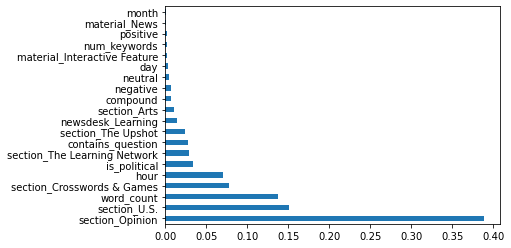

In [53]:
from sklearn.tree import DecisionTreeClassifier

decision_tree = DecisionTreeClassifier(max_depth = 6, random_state = 223,
                                       splitter = "best", criterion = "entropy")

asd_prediction(decision_tree,x_train, y_test_data, y_train, y_labels, "features", threshold_plot=True)

In [37]:
from sklearn.model_selection import GridSearchCV
tree_para = {'criterion':['gini','entropy'],'max_depth':[7,8,9,10,20]}
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
clf = GridSearchCV(RandomForestClassifier(), tree_para, cv=cv)
clf.fit(x_train, y_train)
print("Best parameters: {}".format(clf.best_params_))
print("Best cross-validation score: {:.2f}".format(clf.best_score_))

/opt/homebrew/Caskroom/miniforge/base/envs/anly503/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/opt/homebrew/Caskroom/miniforge/base/envs/anly503/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/opt/homebrew/Caskroom/miniforge/base/envs/anly503/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/opt/homebrew/Caskroom/miniforge/base/envs/anly503/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning:

A column-vect

Best parameters: {'criterion': 'entropy', 'max_depth': 20}
Best cross-validation score: 0.79


/var/folders/gc/n0p2_5d52qz9v6vm5nmmszx40000gn/T/ipykernel_12827/1301569721.py:3: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Accuracy Score: 0.7942227516378797
Confusion Matrix: [[1820  198]
 [ 493  847]]
Area under curve: 0.7669863023830303 

              precision    recall  f1-score   support

         Yes       0.79      0.90      0.84      2018
          No       0.81      0.63      0.71      1340

    accuracy                           0.79      3358
   macro avg       0.80      0.77      0.78      3358
weighted avg       0.80      0.79      0.79      3358



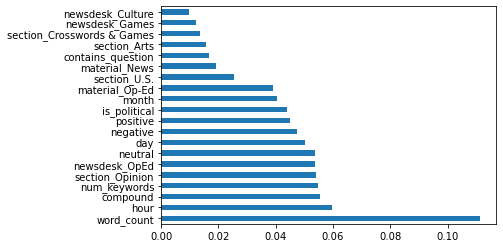

In [52]:
from sklearn.ensemble import RandomForestClassifier

decision_tree = RandomForestClassifier(max_depth = 20, random_state = 42, criterion = "entropy")

asd_prediction(decision_tree, x_train, y_test_data, y_train, y_labels ,"features", threshold_plot=True)

In [ ]:

def cross_val_predict(model, kfold : KFold, X : np.array, y : np.array) -> Tuple[np.array, np.array, np.array]:

    model_ = copy.deepcopy(model)
    
    no_classes = len(np.unique(y))
    
    actual_classes = np.empty([0], dtype=int)
    predicted_classes = np.empty([0], dtype=int)
    predicted_proba = np.empty([0, no_classes]) 

    for train_ndx, test_ndx in kfold.split(X):

        train_X, train_y, test_X, test_y = X[train_ndx], y[train_ndx], X[test_ndx], y[test_ndx]

        actual_classes = np.append(actual_classes, test_y)

        model_.fit(train_X, train_y)
        predicted_classes = np.append(predicted_classes, model_.predict(test_X))

        try:
            predicted_proba = np.append(predicted_proba, model_.predict_proba(test_X), axis=0)
        except:
            predicted_proba = np.append(predicted_proba, np.zeros((len(test_X), no_classes), dtype=float), axis=0)

    return actual_classes, predicted_classes, predicted_proba